In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5,1,'EPIC 220381074')

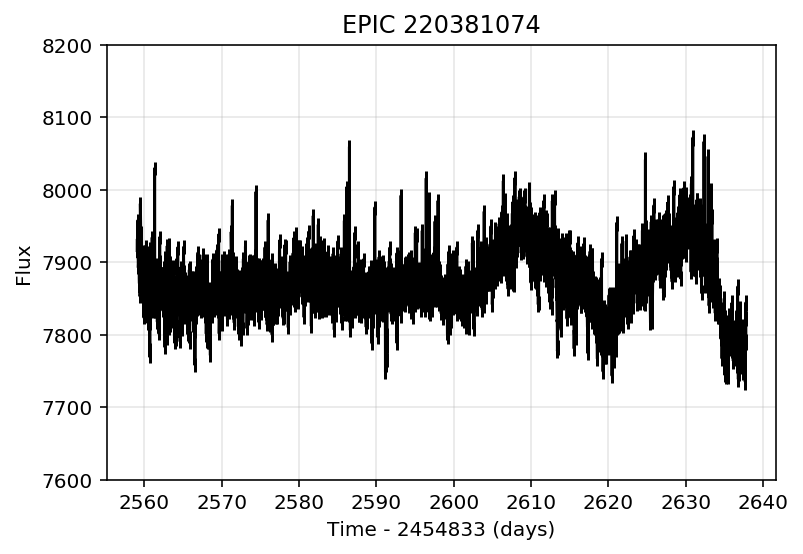

In [14]:
lc = tpf.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers() 

lc.plot(normalize=False)
plt.ylim(7600, 8200)
plt.title('EPIC 220381074')

Now let's create a supernova model using `injection.SupernovaModel` class, and inject it using the `.inject` method.

This supernova will peak in the middle of the lightcurve, have a redshift of 0.5, and an amplitude of 2e-7 e/s/cm^2.

In [15]:
from lightkurve.injection import SupernovaModel
import lightkurve.injection as inj

In [16]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=7.e-7)

Let's plot the model by itself. We do this by evaluating it over the initial lightcurve's timestamps, usng the `.evaluate` method:

In [22]:
model_sn_eval = model.evaluate(lc.time)

And now the model injected into our galaxy:

In [26]:
lcinj = lc.inject(model)

In [25]:
lcinj.background

7789.7870898437495

Text(0.5,1,'EPIC 220381074 With SN')

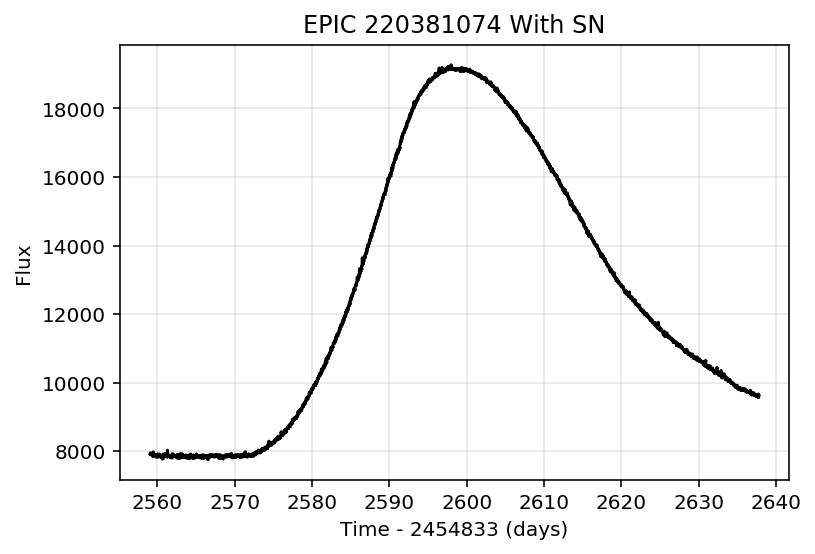

In [27]:
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 With SN')

In [28]:
x0 = [2610, 0.5, 2.0e-7, np.percentile(lc.flux, 3)]

In [29]:
initial_guess={'T0':2610, 'z':0.5, 'amplitude':2.0e-7, 'background':7800}

In [70]:
%%time
x = lcinj.recover_supernova(fit_params=['T0', 'z', 'background'])


7789.7870898437495
['z', 'background', 'T0']
{'z': 0.2, 'background': 7834.852052696217, 'amplitude': 7e-07, 'T0': 2598.0419317560445}
{'z': 0.2000000149011612, 'background': 7834.852052696217, 'amplitude': 7e-07, 'T0': 2598.0419317560445}
{'z': 0.2, 'background': 7834.852052711118, 'amplitude': 7e-07, 'T0': 2598.0419317560445}
{'z': 0.2, 'background': 7834.852052696217, 'amplitude': 7e-07, 'T0': 2598.0419317709457}
{'z': 0.2, 'background': 7834.852052696217, 'amplitude': 7e-07, 'T0': 2598.0419317560445}
{'z': 1.2099747386285447, 'background': 7834.852163015692, 'amplitude': 7e-07, 'T0': 2598.0347892661553}
{'z': 1.2099747386285447, 'background': 7834.852163015692, 'amplitude': 7e-07, 'T0': 2598.0347892661553}
{'z': 1.2099747535297058, 'background': 7834.852163015692, 'amplitude': 7e-07, 'T0': 2598.0347892661553}
{'z': 1.2099747386285447, 'background': 7834.852163030593, 'amplitude': 7e-07, 'T0': 2598.0347892661553}
{'z': 1.2099747386285447, 'background': 7834.852163015692, 'amplitude'

{'z': 0.5000481202584316, 'background': 7873.125387014522, 'amplitude': 7e-07, 'T0': 2600.024088041882}
{'z': 0.5000481202584316, 'background': 7873.125387014522, 'amplitude': 7e-07, 'T0': 2600.024088041882}
{'z': 0.5000481351595928, 'background': 7873.125387014522, 'amplitude': 7e-07, 'T0': 2600.024088041882}
{'z': 0.5000481202584316, 'background': 7873.125387029423, 'amplitude': 7e-07, 'T0': 2600.024088041882}
{'z': 0.5000481202584316, 'background': 7873.125387014522, 'amplitude': 7e-07, 'T0': 2600.024088056783}
{'z': 0.5000473304184792, 'background': 7873.1266996864015, 'amplitude': 7e-07, 'T0': 2600.024084852379}
{'z': 0.5000473304184792, 'background': 7873.1266996864015, 'amplitude': 7e-07, 'T0': 2600.024084852379}
{'z': 0.5000473453196403, 'background': 7873.1266996864015, 'amplitude': 7e-07, 'T0': 2600.024084852379}
{'z': 0.5000473304184792, 'background': 7873.126699701303, 'amplitude': 7e-07, 'T0': 2600.024084852379}
{'z': 0.5000473304184792, 'background': 7873.1266996864015, '

{'z': 0.5000473304138552, 'background': 7873.12669968732, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138552, 'background': 7873.12669968732, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473453150164, 'background': 7873.12669968732, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138552, 'background': 7873.126699702221, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138552, 'background': 7873.12669968732, 'amplitude': 7e-07, 'T0': 2600.02408486724}
{'z': 0.5000473304138564, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138564, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473453150176, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138564, 'background': 7873.12669970222, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138564, 'background': 7873.126699687319, 'amplitude'

{'z': 0.5000473304138564, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473453150176, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138564, 'background': 7873.12669970222, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138564, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.02408486724}
{'z': 0.5000473304138564, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138564, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473453150176, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138564, 'background': 7873.12669970222, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138564, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.02408486724}
{'z': 0.5000473304138564, 'background': 7873.126699687319, 'amplitud

{'z': 0.5000473304138564, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473453150176, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138564, 'background': 7873.12669970222, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138564, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.02408486724}
{'z': 0.5000473304138563, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138563, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473453150175, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138563, 'background': 7873.12669970222, 'amplitude': 7e-07, 'T0': 2600.024084852339}
{'z': 0.5000473304138563, 'background': 7873.126699687319, 'amplitude': 7e-07, 'T0': 2600.02408486724}
{'z': 0.5000473304138564, 'background': 7873.126699687319, 'amplitud

In [ ]:
new_model = inj.SupernovaModel(T0=x['T0'], source='hsiao', bandpass='kepler', z=x['z'], amplitude=x['amplitude'])
new_fit = new_model.evaluate(lc.time) + x['background']


Text(0,0.5,'Flux')

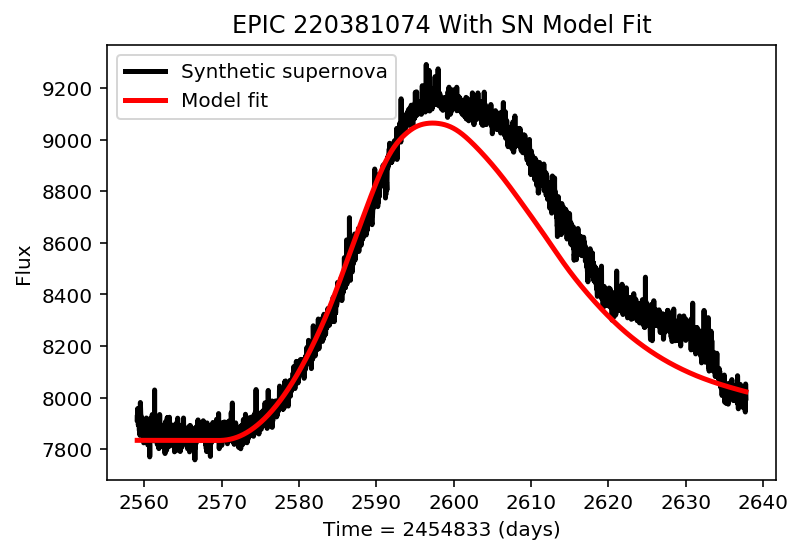

In [66]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

In [16]:
%%time
sampler = lcinj.recover_supernova(fit_params=['T0', 'z', 'amplitude', 'background'], method='mcmc', nwalkers=8, nsteps=8)


CPU times: user 14.2 s, sys: 1.51 s, total: 15.7 s
Wall time: 8.19 s


In [19]:
new_model = inj.SupernovaModel(T0=x['T0'], source='hsiao', bandpass='kepler', z=x['z'], amplitude=8.e-8)
new_fit = new_model.evaluate(lc.time) + x['background']



Text(0,0.5,'Flux')

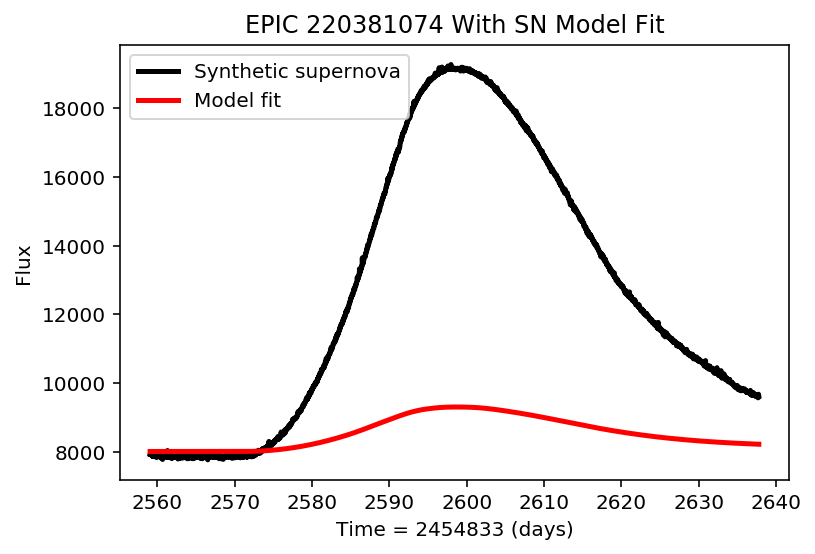

In [20]:
plt.plot(lcinj.time, lcinj.flux, label='Synthetic supernova', color='k', lw='2.5')
plt.plot(lcinj.time, new_fit, label = 'Model fit', color='r', lw='2.5')
plt.legend()
plt.title('EPIC 220381074 With SN Model Fit')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

/Users/sheilasagear/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


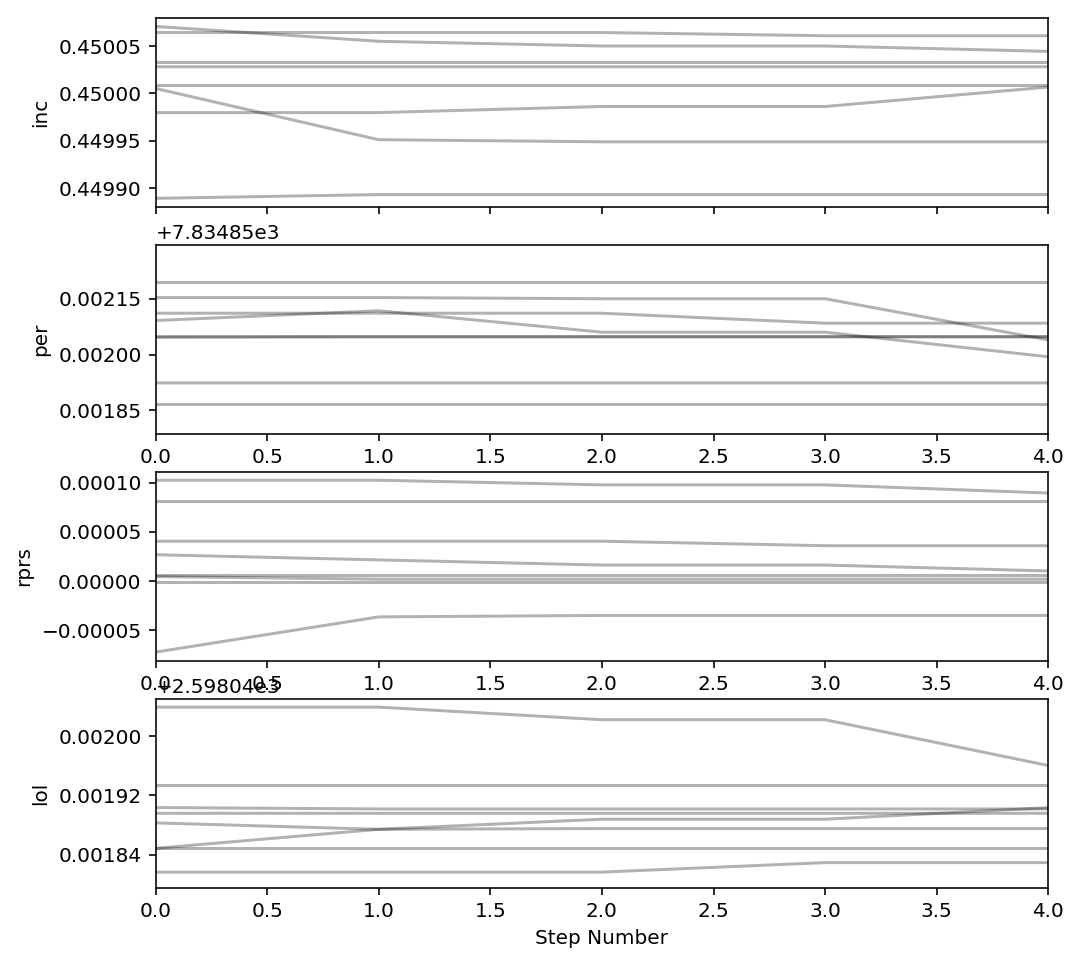

In [18]:
from matplotlib.ticker import MaxNLocator

samples = sampler.chain
labels = ['inc', 'per', 'rprs', 'lol']

fig1 = plt.figure(figsize=[8, 8])
for i in range(samples.shape[-1]):
    ax = fig1.add_subplot(4, 1, i + 1)
    ax.plot(sampler.chain[:, 0:1000, i].T, "k", alpha=0.3)
    ax.set_xlim(0, sampler.chain.shape[1])
    if i < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Step Number")
    ax.set_ylabel(labels[i])
    ax.yaxis.set_major_locator(MaxNLocator(4))

    plt.xlim(0, 4)
fig1.show()

In [39]:
x, y = inj.injection_and_recovery(lc, "Supernova", 
    5, 0.1, T0=2600, z=inj.UniformDistribution(0.1,0.3), 
    amplitude = inj.GaussianDistribution(3.e-7, 1.e-7))
                                  
                                  
                                  

(2600, 0.15894463771238537, 2.312270272451521e-08)
{'T0': 2598.0419317560445, 'z': 0.19999999999999712, 'amplitude': 1.9017632332894146e-08, 'background': 7826.925729727953}
(2600, 0.11067569005159938, 3.760268290248218e-07)
{'T0': 2600.573901309998, 'z': 0.22399438850993586, 'amplitude': 3.087399278276665e-07, 'background': 7925.304111992406}
(2600, 0.18714547590730488, 1.3802834054955425e-07)
{'T0': 2600.1328701208276, 'z': 0.28553444216320284, 'amplitude': 1.1173296106834974e-07, 'background': 7916.60160950552}
(2600, 0.20817318460305, 2.5934312505832796e-07)
{'T0': 2600.372819882819, 'z': 0.26733909455090055, 'amplitude': 2.2836163863876793e-07, 'background': 7947.702935926769}
(2600, 0.21159126417733415, 2.092421950523473e-07)
{'T0': 2599.8132002417974, 'z': 0.2521400041881865, 'amplitude': 1.880976441727712e-07, 'background': 7924.651672884201}


In [90]:
x, y = inj.injection_and_recovery(lc, "Supernova", 
    5, 0.1, T0=2600, z=inj.UniformDistribution(0.1,0.3), 
    amplitude = inj.GaussianDistribution(3.e-7, 1.e-7))

(2600, 0.16429241874738001, 3.1784046203396065e-07)
['z', 'amplitude']
{'z': 0.2179626094382856, 'amplitude': 3.020774813706823e-07}
{'z': 0.2179626094382856, 'amplitude': 3.020774813706823e-07, 'T0': 2600}
(2600, 0.2646828770683721, 4.054654044968007e-07)
['z', 'amplitude', 'z', 'amplitude']
{'z': 0.26742703830511727, 'amplitude': 4.107541428583859e-07}
{'z': 0.26742703830511727, 'amplitude': 4.107541428583859e-07, 'T0': 2600}
Recovered - T0: 2600 amplitude: 4.05465404497e-07 z: 0.264682877068
(2600, 0.1603168022847837, 3.190964758969768e-07)
['z', 'amplitude', 'z', 'amplitude', 'z', 'amplitude']
{'z': 0.21740885774794627, 'amplitude': 3.0165553041823634e-07}
{'z': 0.21740885774794627, 'amplitude': 3.0165553041823634e-07, 'T0': 2600}
(2600, 0.2459630689549767, 3.123251140670321e-07)
['z', 'amplitude', 'z', 'amplitude', 'z', 'amplitude', 'z', 'amplitude']
{'z': 0.26394860418639965, 'amplitude': 3.167729315022962e-07}
{'z': 0.26394860418639965, 'amplitude': 3.167729315022962e-07, 'T0': 

In [30]:
import lightkurve.injection as inj

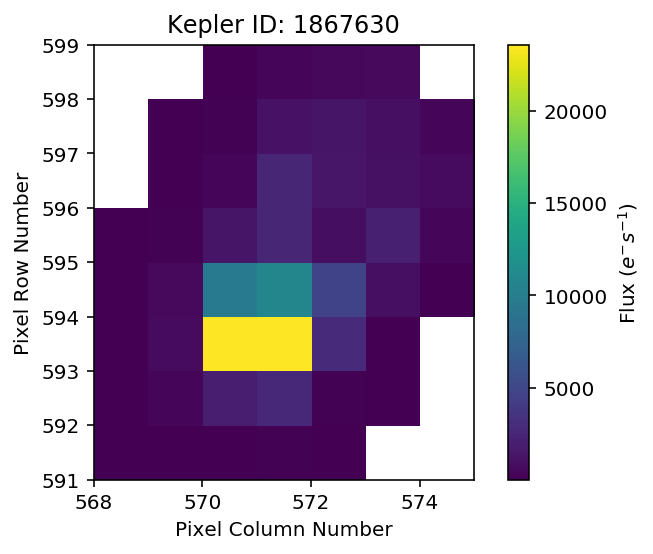

In [31]:
tpf_star = KeplerTargetPixelFile.from_archive(1867630, quarter=1)
tpf_star.plot()

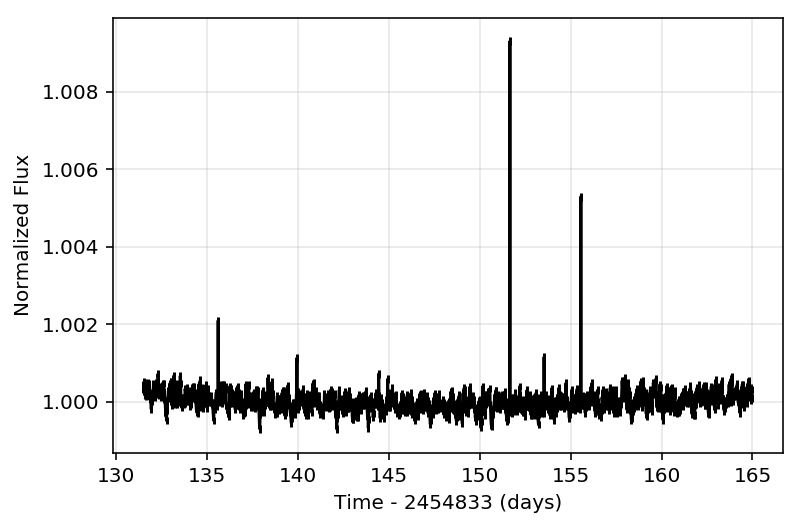

In [32]:
lc_star = tpf_star.to_lightcurve(aperture_mask='all')
lc_star.plot()

I am going to normalize this light curve, because we are multiplying in a normalized transit lightcurve.

Text(0.5,0,'Time (days)')

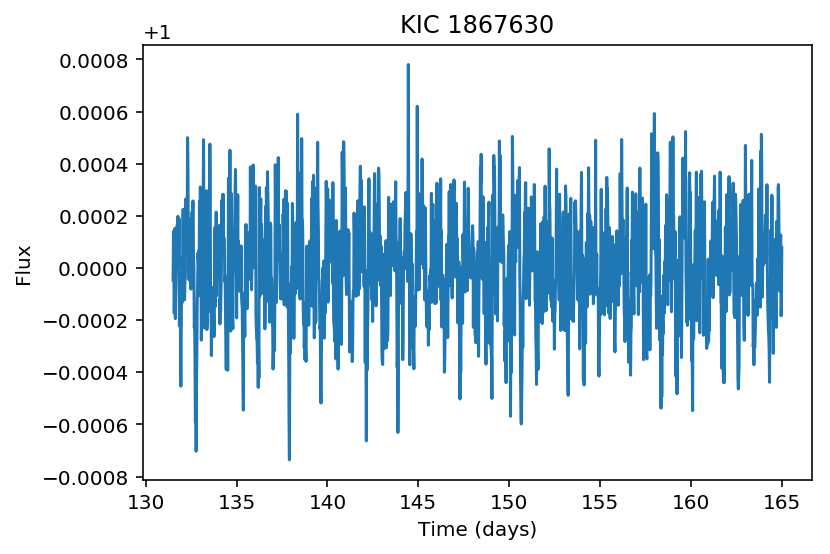

In [33]:
lc_star = lc_star.remove_nans().remove_outliers()
lc_star = lc_star.normalize().flatten()

plt.plot(lc_star.time, lc_star.flux)
plt.title('KIC 1867630')
plt.ylabel('Flux')
plt.xlabel('Time (days)')

Now I'm injecting a lightcurve of a Jupiter-sized planet with an orbital period of 5 days.

In [34]:
import batman
from lightkurve.injection import GaussianDistribution

In [98]:
model = inj.TransitModel()
model.add_planet(period=8.680437138294703, rprs=0.14674050301384417, T0=133, inc=87)

In [99]:
lc_transit = lc_star.inject(model)

In [100]:
lc_transit

SyntheticLightCurve: Planet

Let's plot just the model:

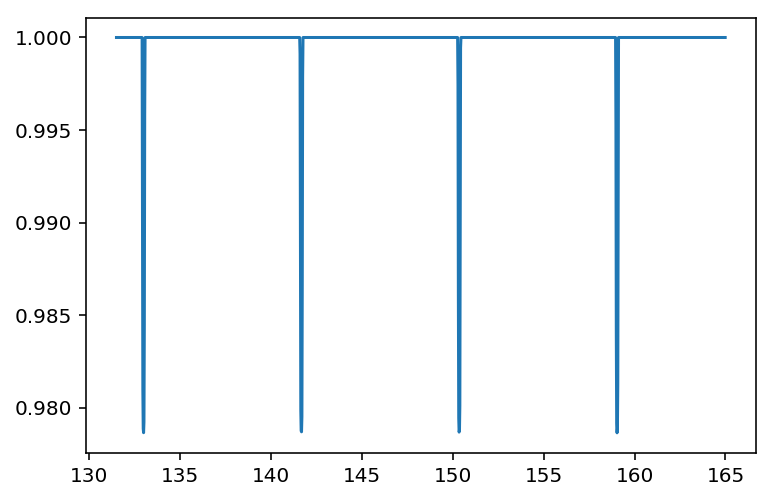

In [101]:
model_eval = model.evaluate(lc_star.time.astype(np.float))
plt.plot(lc_transit.time, model_eval)

And now the injected lightcurve:

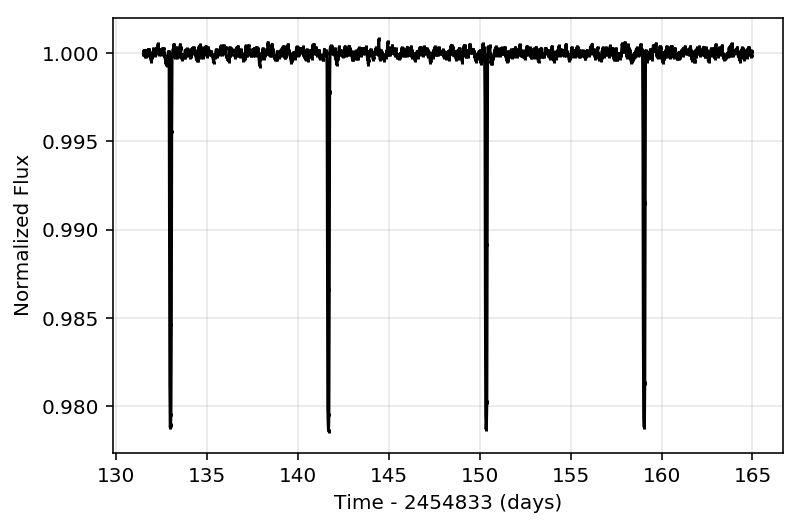

In [102]:
lc_transit.plot()

Now let's recover the transits using the `.recover` method with `signaltype = 'Planet'`.

In [103]:
lc_transit.recover_planet()

{'period': 8.680481200216482, 'rprs': 0.14628326226126975}

In [173]:
x, y = inj.injection_and_recovery(lc_star, "Planet", 
    10, 0.03, period=inj.UniformDistribution(5,10), 
    rprs=inj.UniformDistribution(0.1, 0.15), inc=inj.GaussianDistribution(88,0.5))

Recovered - period: 9.43989464724 rprs: 0.129995001167 inc: 88.1543415915
Recovered - period: 7.14410627948 rprs: 0.124773537387 inc: 88.5493233774
Recovered - period: 6.36637383915 rprs: 0.130891009465 inc: 88.5791351545
Recovered - period: 6.21034018237 rprs: 0.109572561996 inc: 88.9411065305


In [174]:
x

period,rprs,T0,inc,a,ecc,w
float64,float64,float64,float64,float64,float64,float64
9.439894647243126,0.12999500116665116,5.0,88.15434159153645,15.0,0.0,90.0
7.144106279483982,0.1247735373870105,5.0,88.54932337739052,15.0,0.0,90.0
6.366373839152272,0.1308910094654296,5.0,88.57913515450812,15.0,0.0,90.0
6.210340182369753,0.10957256199588855,5.0,88.94110653053771,15.0,0.0,90.0


In [152]:
type(x)

dict

In [ ]:
 and abs(results['a']-a_t) < constr*a_t and abs(results['ecc']-ecc_t) < constr*ecc_t and abs(results['w']-w_t) < constr*w_t